# 02. Modeling

Entrenar un modelo "Caja Negra" robusto (Random Forest).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

REPORT_IMG_DIR = "../report/images"
os.makedirs(REPORT_IMG_DIR, exist_ok=True)


## 1. Cargar Datos

In [6]:
PROCESSED_DIR = "../data/processed"
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")

X_train = train_df.drop(columns=['Target'])
y_train = train_df['Target']
X_val = val_df.drop(columns=['Target'])
y_val = val_df['Target']

Train: (600, 21)
Val: (200, 21)


## 2. Pipeline de Preprocesamiento
Detectamos columnas categóricas y numéricas.

In [ ]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", len(cat_cols))
print("Numerical features:", len(num_cols))

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    verbose_feature_names_out=False 
)

Categorical features: 13
Numerical features: 7


## 3. Entrenamiento (Random Forest)

In [8]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'))
])

print("Training model...")
model_pipeline.fit(X_train, y_train)
print("Training complete.")

Training model...
Training complete.


## 4. Evaluación

ROC-AUC Score: 0.7425

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       140
           1       0.53      0.45      0.49        60

    accuracy                           0.71       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.70      0.71      0.71       200



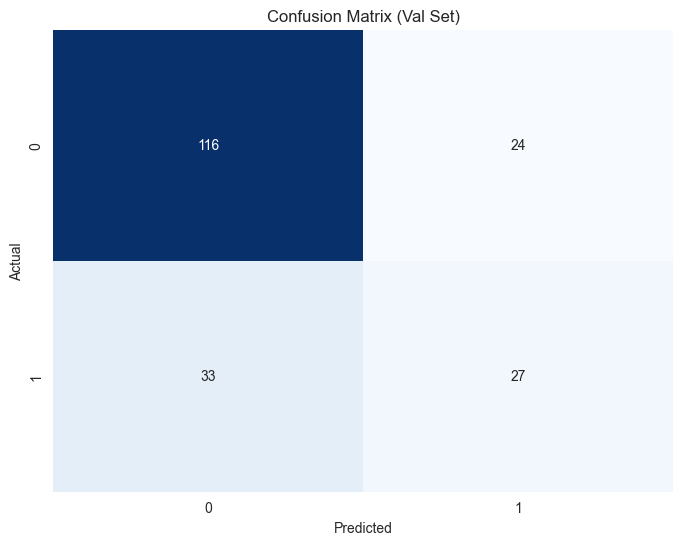

<Figure size 1000x600 with 0 Axes>

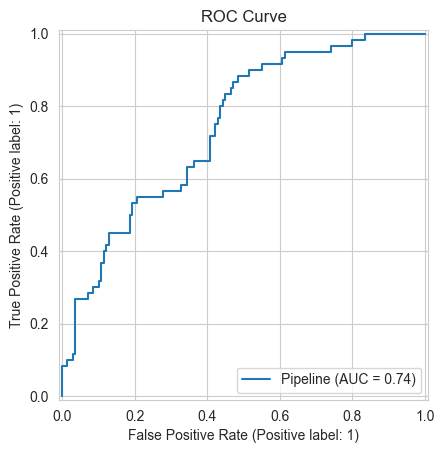

In [11]:
# Predicciones
y_pred_val = model_pipeline.predict(X_val)
y_pred_proba_val = model_pipeline.predict_proba(X_val)[:, 1]

# Métricas
roc = roc_auc_score(y_val, y_pred_proba_val)
print(f"ROC-AUC Score: {roc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

# Matriz de Confusión
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Val Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(REPORT_IMG_DIR, "04_confusion_matrix.png"), dpi=300)
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(model_pipeline, X_val, y_val)
plt.title("ROC Curve")
plt.grid(True)
plt.savefig(os.path.join(REPORT_IMG_DIR, "03_roc_curve.png"), dpi=300)
plt.show()


## 5. Guardar Modelo

In [ ]:
MODELS_DIR = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

model_path = os.path.join(MODELS_DIR, "rf_model.joblib")
joblib.dump(model_pipeline, model_path)
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
joblib.dump(feature_names, os.path.join(MODELS_DIR, "feature_names.joblib"))

Model saved to ../models\rf_model.joblib
Feature names saved, count: 61
